In [1]:
comment = 'calculated in LINE.ipynb'

In [2]:
emb_dir = '.' #'data/LINE'
line1_file = emb_dir + '/LINE1.txt'
line2_file = emb_dir + '/LINE2.txt'

In [3]:
%matplotlib inline
#%matplotlib notebook
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.insert(0,'../..')
from HigherOrderPathGenerator import ABCHigherOrderPathGenerator
from Embedding import Generic_SkipGram_Embedding
from SyntheticNetworks import create_lattice_2nd_order_dynamic
from Visualizations import Visualization

In [5]:
size = 10
omega = 0
latgen = create_lattice_2nd_order_dynamic(size, omega, lattice_sep='-', check=True)

[]
[]


The embeddings have been learned using https://github.com/tangjianpku/LINE

```.\line -train edges.txt -output LINE1.txt -order 1 -binary 0 -size 16 -threads 1 -negative 1
.\line -train edges.txt -output LINE2.txt -order 2 -binary 0 -size 16 -threads 1 -negative 1```

In [6]:
config=dict(size=16, negative=1)
emb1 = Generic_SkipGram_Embedding(latgen, line1_file, config=dict(order=1, **config))
emb2 = Generic_SkipGram_Embedding(latgen, line2_file, config=dict(order=2, **config))

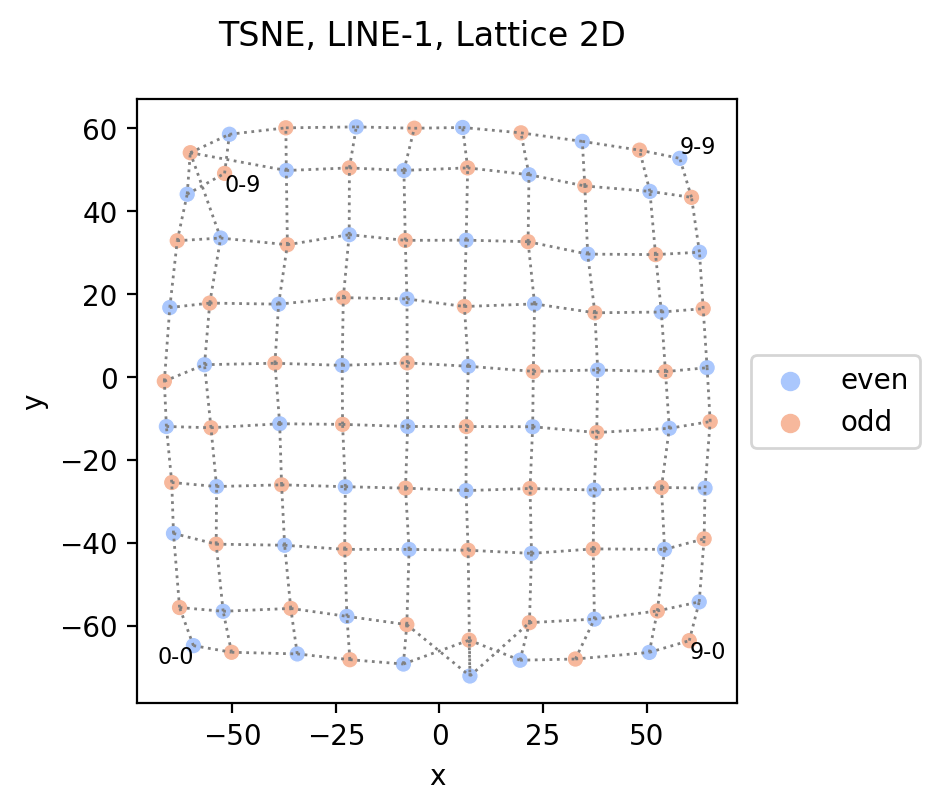

In [7]:
vis1 = emb1.source.visualize_TSNE(random_state=4, n_iter=1500, learning_rate=250, perplexity=20, title='TSNE, LINE-1, Lattice 2D')
vis1.plot1(hue='parity')
vis1.annotate_node('0-0', ha='right', va='top')
vis1.annotate_node('9-9', ha='left', va='bottom')
vis1.annotate_node('0-9', ha='left', va='top')
vis1.annotate_node('9-0', ha='left', va='top')
##
vis1.save_describe('tsne_line1_synth_parity.png', comment) # figure 2.2 (left)

In [8]:
if False:
    for x in range(20):
        vis = emb1.source.visualize_TSNE(random_state=x, n_iter=1500, learning_rate=250, perplexity=20)
        vis.plot1(figsize=(5,5), dpi=400, hue='parity')

paths: Lattice2D(10, omega=0.000000)
embedding: LINE1
dim: (180, 4)
embedding columns: ['len', 'angle']
other columns: ['angle360', 'direction']

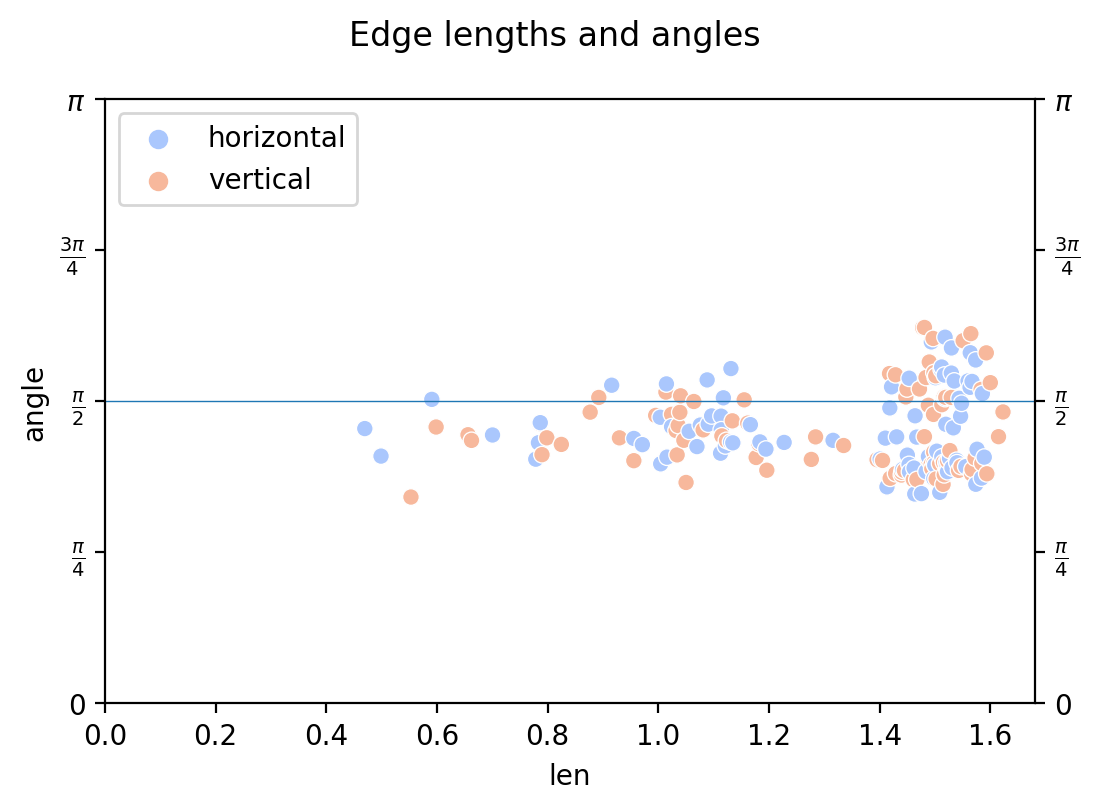

In [9]:
emb1.source.visualize_edges_len_angle() # plot not shown in thesis

In [10]:
#emb1.embedding.head()

In [11]:
emb2.source.edge_distance=2
vis2 = emb2.source.visualize_TSNE(random_state=7, n_iter=1500, learning_rate=350, perplexity=10, title='TSNE, LINE-2, Lattice 2D')
#vis2.plot1(hue='parity')

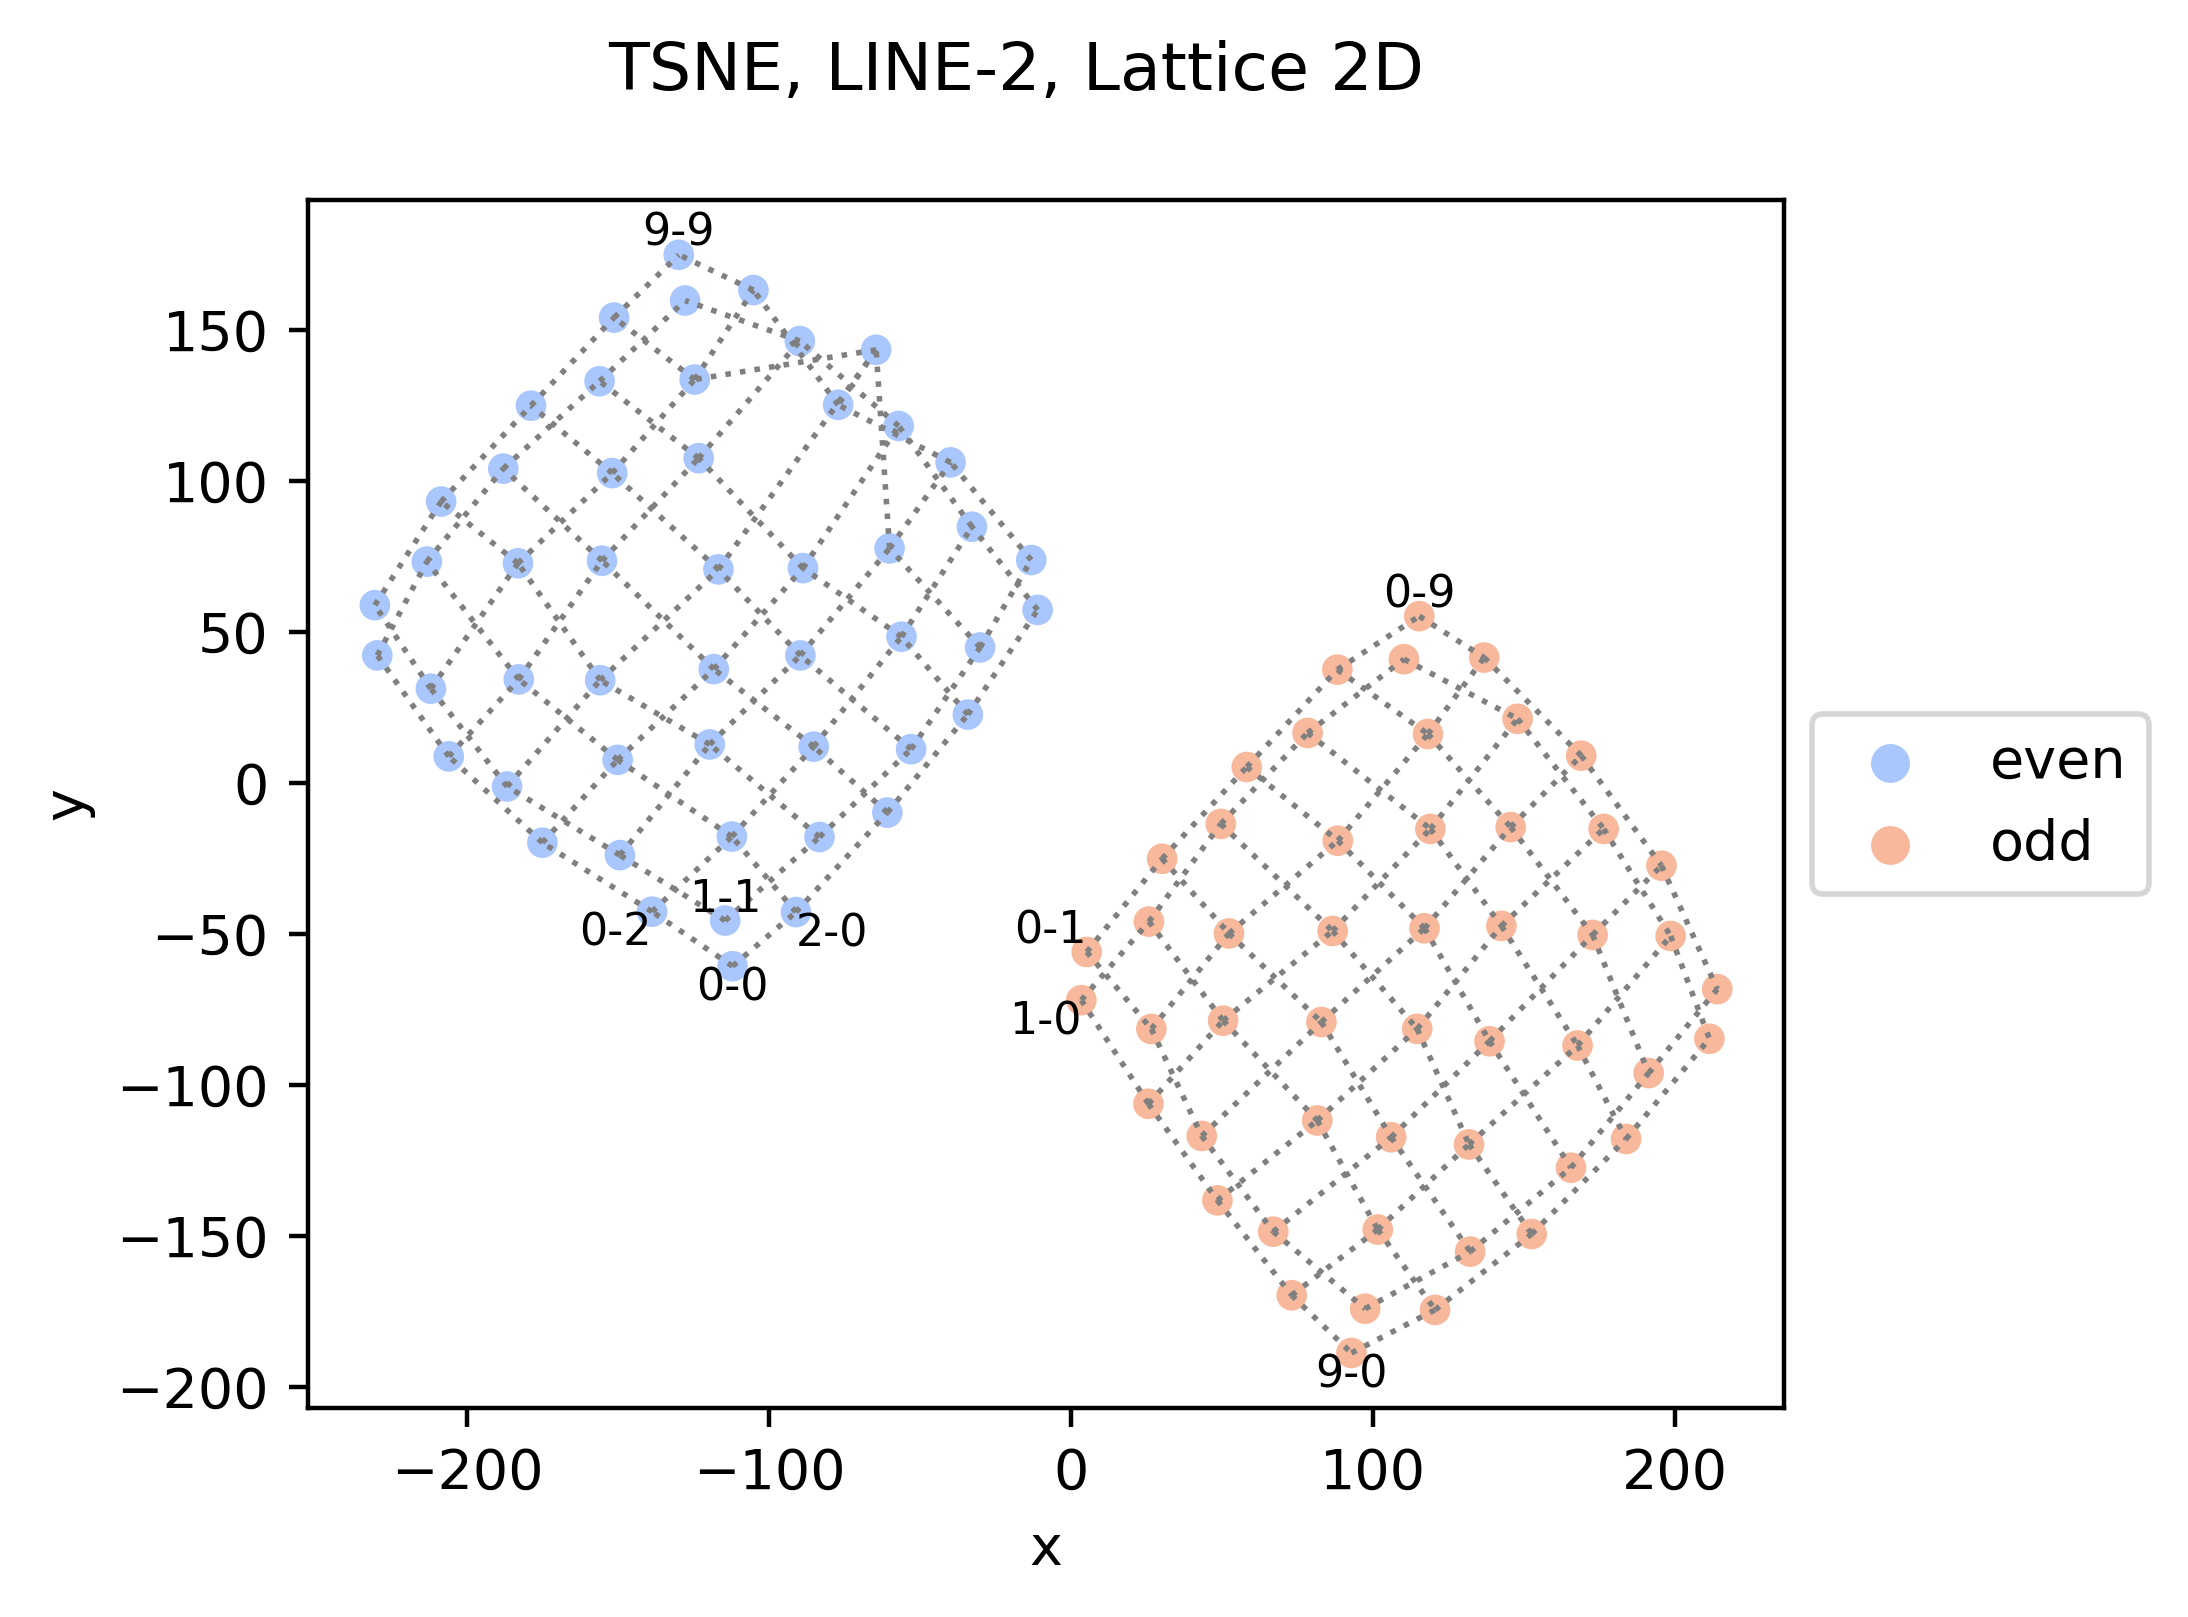

In [12]:
#vis2.plot1(figsize=(5,5), dpi=400, hue='parity')
vis2.plot1(dpi=400, hue='parity')
vis2.annotate_node('0-0', ha='center', va='top')
vis2.annotate_node('1-1', ha='center', va='bottom')
vis2.annotate_node('0-2', ha='right', va='top')
vis2.annotate_node('2-0', ha='left', va='top')
vis2.annotate_node('9-9', ha='center', va='bottom')
vis2.annotate_node('0-1', ha='right', va='bottom')
vis2.annotate_node('1-0', ha='right', va='top')
vis2.annotate_node('0-9', ha='center', va='bottom')
vis2.annotate_node('9-0', ha='center', va='top')
##
vis2.save_describe('tsne_line2_synth_parity.png', comment) # figure 2.2 (right)

In [13]:
#emb2.embedding.head()

In [14]:
if False:
    for x in range(20):
        vis = emb2.source.visualize_TSNE(random_state=x, n_iter=1500, learning_rate=200, perplexity=30)
        vis.plot1(figsize=(5,5), dpi=400, hue='parity')

paths: Lattice2D(10, omega=0.000000)
embedding: LINE2
dim: (160, 4)
embedding columns: ['len', 'angle']
other columns: ['angle360', 'direction']

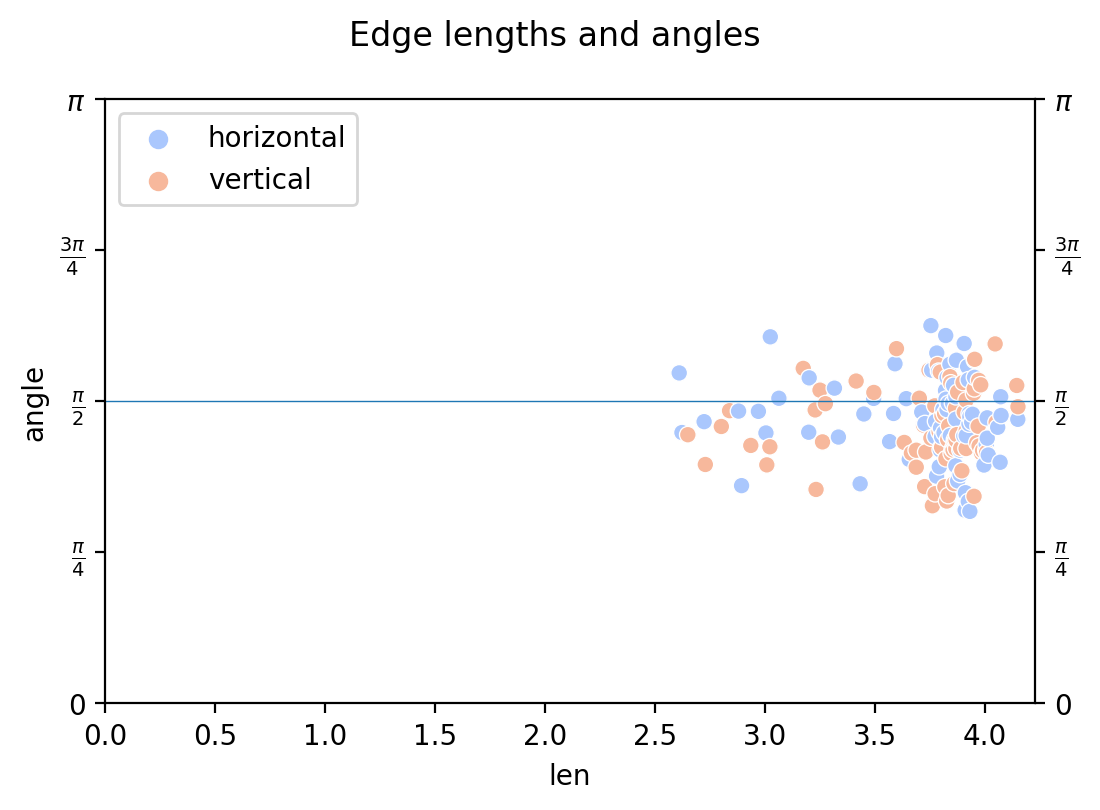

In [15]:
emb2.source.visualize_edges_len_angle() # plot not shown in thesis

In [16]:
from collections import defaultdict
def calc_node_pair_stats(ev, max_dist=2):
    pairs_dist = dict()
    for path,_ in ev._emb._gen.path_probs(start=(), num_steps=max_dist+1):
        u=path[0]
        for i,v in enumerate(path):
            pairs_dist[(u,v)] = min(i, pairs_dist.get((u,v),i)) # minimal distance between pairs of nodes
    stats = defaultdict(list)
    for (u,v),dist in pairs_dist.items():
        key_u, key_v = ev.node2key(u), ev.node2key(v)
        e_u = ev._embedding[ev._keys_dict[key_u]] # = self.embedding.loc[key2str(start)]
        e_v = ev._embedding[ev._keys_dict[key_v]] # = self.embedding.loc[key2str(end)]
        stats['key'].append(f'{key_u} -> {key_v}')
        stats['distance'].append(dist)
        len_u = np.linalg.norm(e_u)
        len_v = np.linalg.norm(e_v)
        stats['len'].append((len_u*len_v)**0.5)
        spr = e_u @ e_v
        stats['angle'].append(np.arccos(np.clip(spr/len_u/len_v, -1, 1)))
    df = pd.DataFrame(stats).set_index('key')   
    return df
calc_node_pair_stats(emb2.source).head()

,distance,len,angle
key,,,
0-0 -> 0-0,0,4.004053,0.000000
0-0 -> 1-0,1,4.175996,1.255705
0-0 -> 2-0,2,4.205854,0.691309
0-0 -> 1-1,2,4.215523,0.483029
0-0 -> 0-1,1,4.162502,1.468553


In [17]:
# from EmbeddingData_Lattice2D.visualize_edges_len_angle
def plot_embedding_edge_len_angles(ev, title, max_dist=2, figsize=(6,4), dpi=200, figureargs=dict(), **kwargs):
    cols = ['len','angle']
    stats = calc_node_pair_stats(ev, max_dist)
    vis = Visualization(ev, title, stats, cols, config, edges=None)
    vis.plot1(figsize=figsize, dpi=dpi, hue='distance', figureargs=figureargs, **kwargs) 
    ax = vis._figure.gca()
    ax.set_aspect('auto')
    ax.set_xlim(0, None)
    ax.set_ylim(0, math.pi)
    ax.tick_params(labelright=True, right=True)
    ax.set_yticks(math.pi * np.linspace(0,1,num=5))
    ax.set_yticklabels(['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$'])
    ax.hlines(math.pi/2, *ax.get_xlim(),linewidths=0.5)
    ax.legend(loc='upper left')
    vis._figure_config['workaround'] = 'see visualize_edges_len_angle' # let save_describe() know about this workaround
    return vis

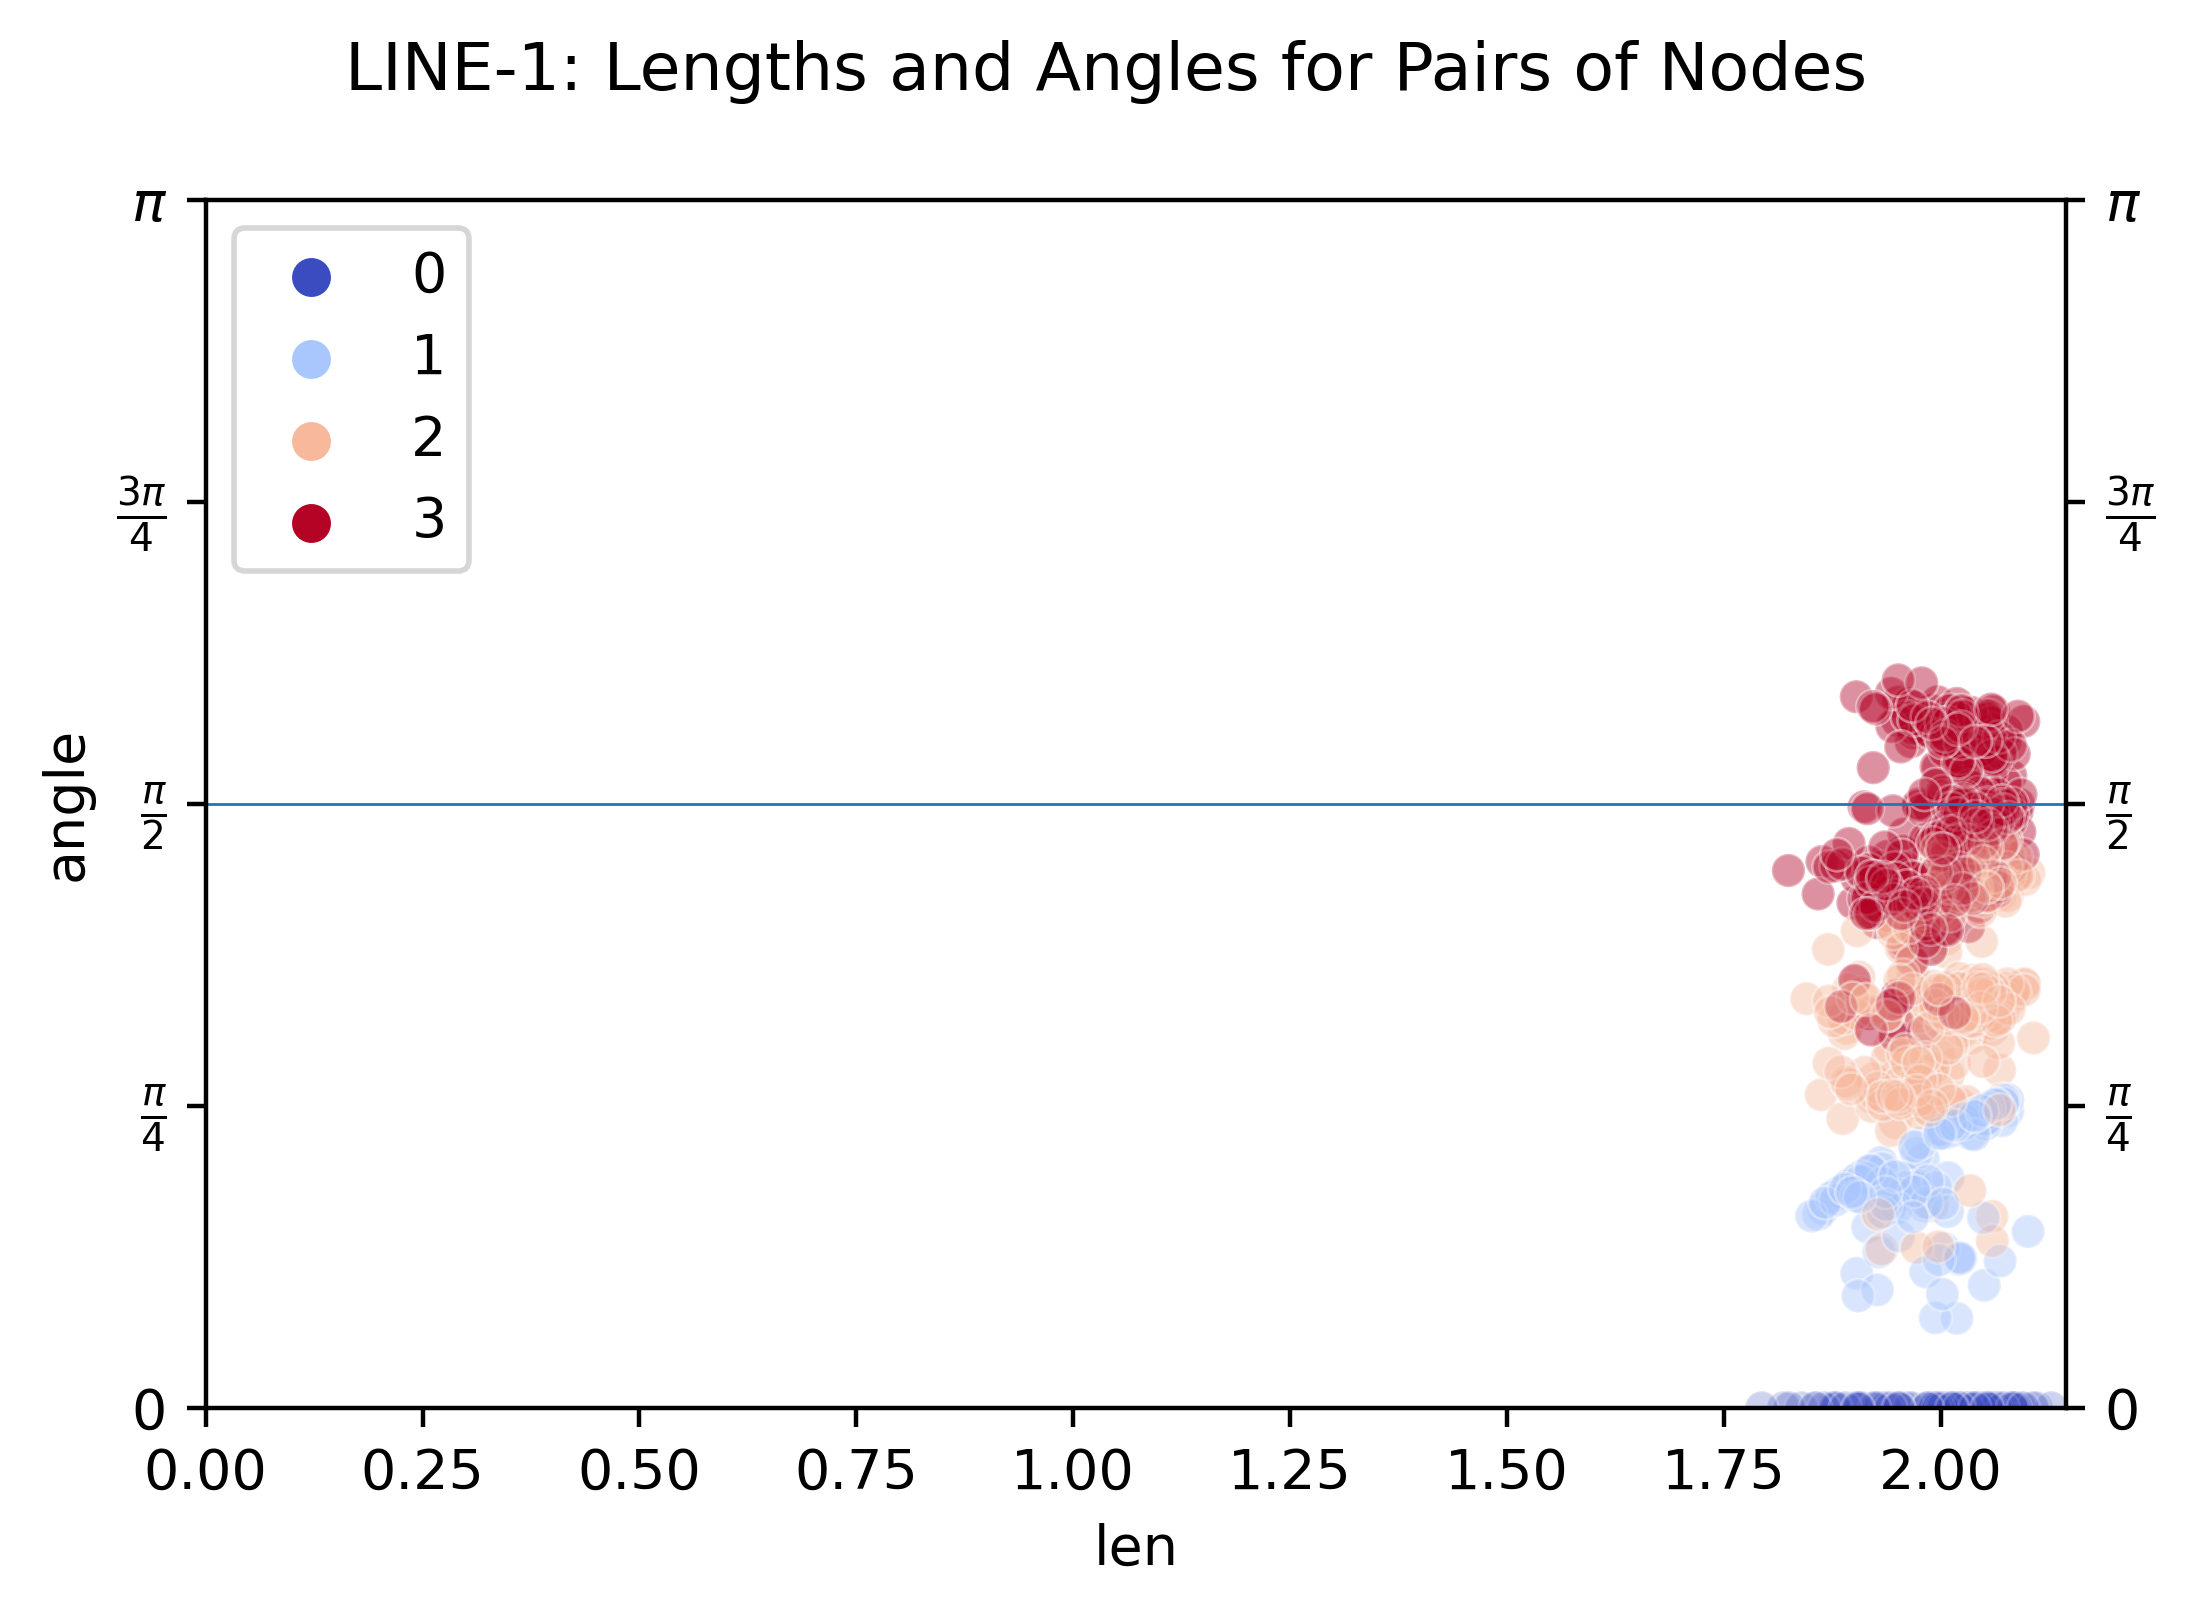

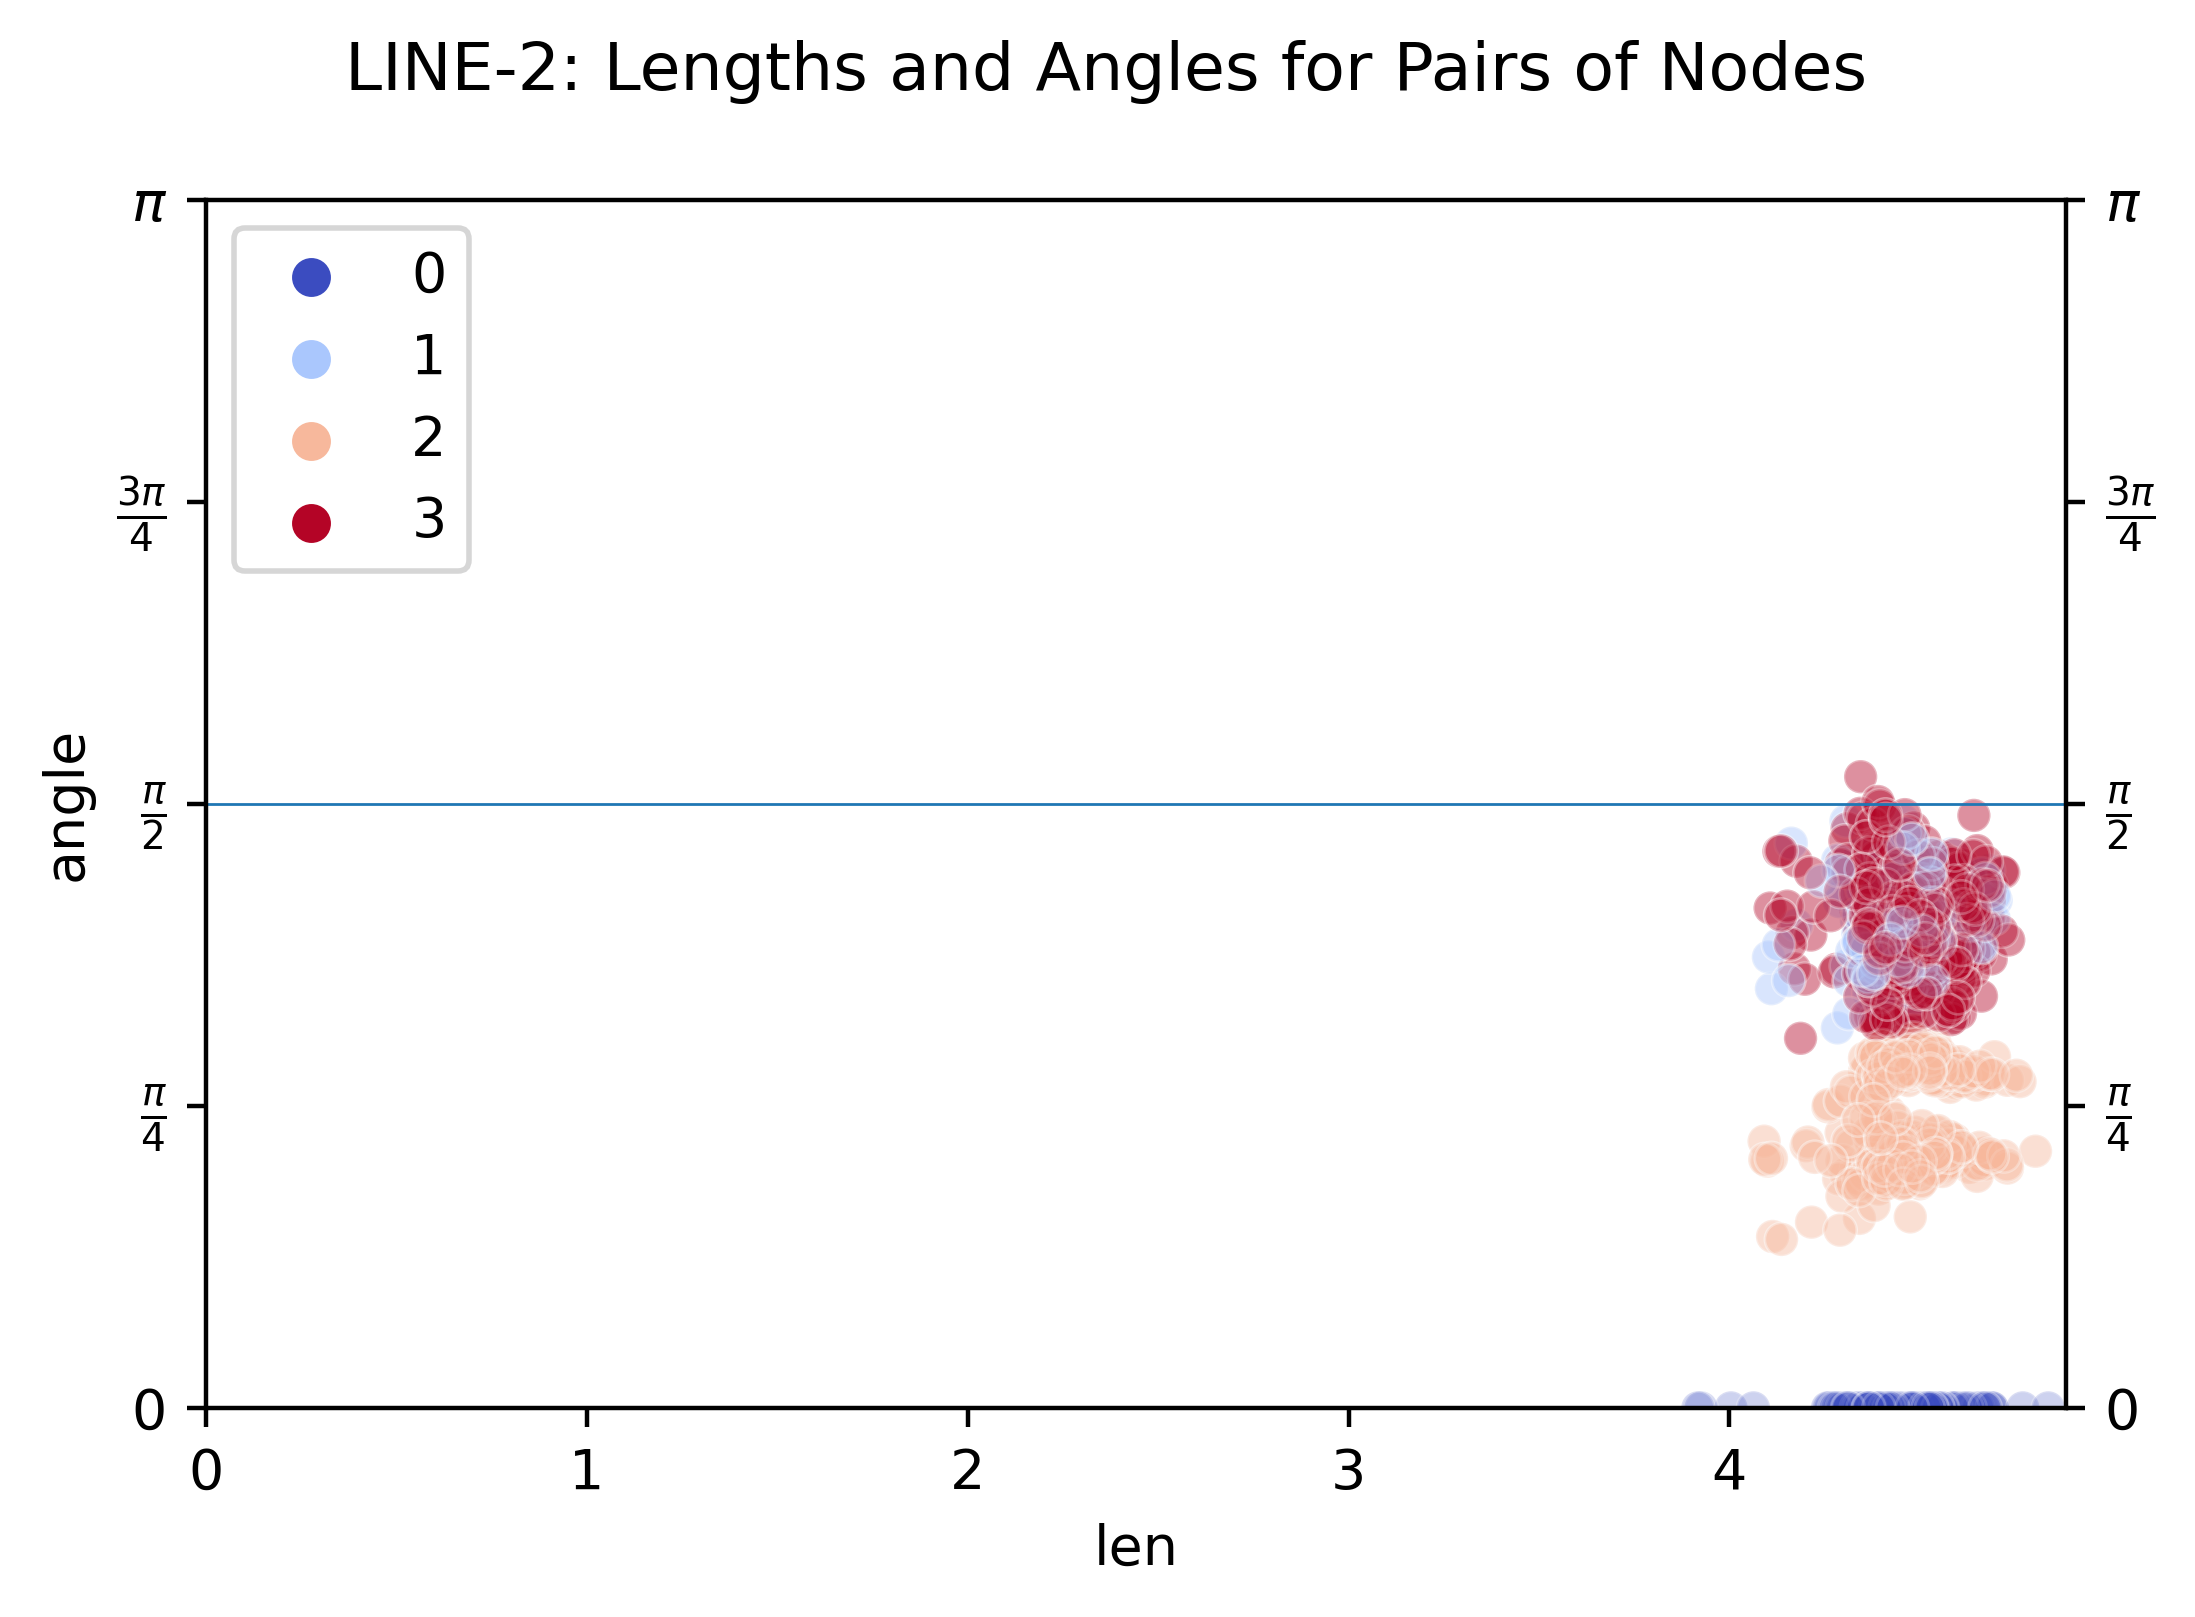

In [18]:
# figure 2.1
title_fmt = 'LINE-%d: Lengths and Angles for Pairs of Nodes'
plot_para = dict(max_dist=3, alpha=0.25, dpi=400)#, palette='tab10')
plot_embedding_edge_len_angles(emb1.source, title_fmt%1, **plot_para).save_describe('len-angle_line1_synth_distance.png')
plot_embedding_edge_len_angles(emb2.source, title_fmt%2, **plot_para).save_describe('len-angle_line2_synth_distance.png')